In [1]:
# First, install required packages using pip:

!pip install numpy pandas opencv-python matplotlib kagglehub tqdm
!pip install tensorflow
!pip install scikit-learn
!pip install mediapipe


  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 794.1 kB/s eta 0:00:00m eta -:--:--
Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.4 MB/s eta 0:00:001.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 692.2 kB/s eta 0:00:00B/s eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 562.8 kB/s eta 0:00:001m485.3 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 2.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 2.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 1.6 MB/s eta 0:00:001.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.5 MB/s eta 0:00:000:00:01m eta 0:0

In [2]:
# Organized imports
# General Data Processing and Visualization
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import kagglehub
from tqdm import tqdm

# Deep Learning Framework - TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Input,
    SpatialDropout2D
)
from tensorflow.keras.utils import to_categorical, Sequence  # Fixed typo in 'Sequence'
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Machine Learning Tools - Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Computer Vision and Real-time Processing
import mediapipe as mp

# Memory Management
import gc

print("All libraries loaded successfully!")

# Optional: Check versions
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

2025-01-15 07:49:22.127510: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 07:49:22.131328: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-15 07:49:22.142449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736907562.161213  157025 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736907562.166836  157025 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 07:49:22.186627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

All libraries loaded successfully!
TensorFlow version: 2.18.0
OpenCV version: 4.10.0
NumPy version: 1.26.4
Pandas version: 2.2.3


In [ ]:
# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

 15%|█████████▍                                                     | 157M/1.03G [01:14<05:25, 2.87MB/s]

In [ ]:
def load_data_in_chunks(train_path, chunk_size=1000, target_size=(64, 64)):
    # Get all classes (folders)
    classes = [folder for folder in os.listdir(train_path)
              if os.path.isdir(os.path.join(train_path, folder))]

    # First pass: count total number of valid images
    total_images = 0
    for letter_folder in classes:
        letter_path = os.path.join(train_path, letter_folder)
        files = [f for f in os.listdir(letter_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        total_images += len(files)

    # Pre-allocate arrays
    X_train = np.zeros((total_images, target_size[0], target_size[1], 3), dtype=np.uint8)
    y_train = np.empty(total_images, dtype=object)

    # Load images in chunks
    current_idx = 0
    for letter_folder in tqdm(classes, desc="Processing classes"):
        letter_path = os.path.join(train_path, letter_folder)
        files = [f for f in os.listdir(letter_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Process files in chunks
        for i in range(0, len(files), chunk_size):
            chunk_files = files[i:i + chunk_size]

            for file in chunk_files:
                img_path = os.path.join(letter_path, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img_resized = cv2.resize(img, target_size)
                    X_train[current_idx] = img_resized
                    y_train[current_idx] = letter_folder
                    current_idx += 1

            # Optional: Clear memory
            if i % (chunk_size * 5) == 0:
                gc.collect()

    # Trim arrays if some images were invalid
    if current_idx < total_images:
        X_train = X_train[:current_idx]
        y_train = y_train[:current_idx]

    return X_train, y_train


train_path = path + "/asl_alphabet_train/asl_alphabet_train"
chunk_size = 1000  # Adjust based on available memory
target_size = (64, 64)

# Load data
print("Starting data loading...")
X_train, y_train = load_data_in_chunks(
    train_path=train_path,
    chunk_size=chunk_size,
    target_size=target_size
)

print(f"\nTraining dataset loaded:")
print(f"Number of images: {len(X_train)}")
print(f"Image shape: {X_train[0].shape}")
print(f"Number of unique classes in X: {len(np.unique(X_train))}")
print(f"Number of images in y: {len(y_train)}")
print(f"Number of unique classes in y: {len(np.unique(y_train))}")

Starting data loading...


Processing classes: 100%|██████████| 29/29 [00:35<00:00,  1.23s/it]



Training dataset loaded:
Number of images: 87000
Image shape: (64, 64, 3)


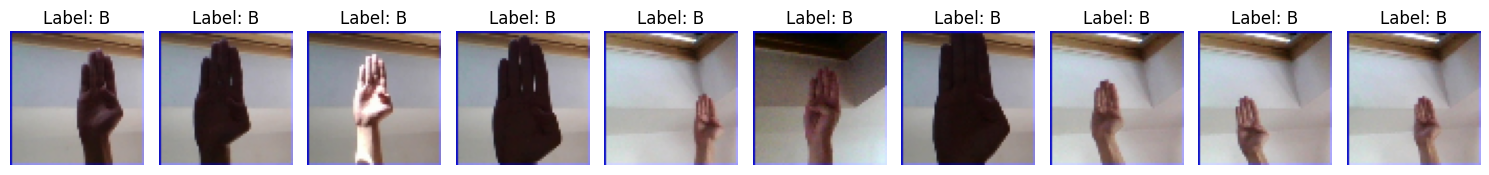

In [ ]:
num_samples = 10
plt.figure(figsize=(15, 5))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(cv2.cvtColor(X_train[i+30000], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.title(f"Label: {y_train[i+30000]}")
    plt.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
test_path = path + "/asl_alphabet_test/"

# # Print the full directory structure
# for root, dirs, files in os.walk(test_path):
#     print(f"\nDirectory: {root}")
#     print("Subdirectories:", dirs)
#     print("Files:", files[:])  # Show first 5 files only to avoid cluttering

batch_size = 500  # Adjust batch size based on available memory
test_images = []
test_labels = []

# Get all classes (folders)
classes = [folder for folder in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, folder))]

print("Starting batch-wise loading for the test dataset...")
for letter_folder in classes:
    letter_path = os.path.join(test_path, letter_folder)
    print(f"Loading class: {letter_folder}")

    files = [f for f in os.listdir(letter_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    total_files = len(files)
    num_batches = (total_files + batch_size - 1) // batch_size  # Calculate the number of batches

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, total_files)

        for file in files[start_idx:end_idx]:
            img_path = os.path.join(letter_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, target_size)
                test_images.append(img_resized)
                if file[0] == 's':
                    test_labels.append('space')
                elif file[0] == 'n':
                    test_labels.append('nothing')
                elif file[0] == 'd':
                    test_labels.append('del')
                else:
                    test_labels.append(file[0])

        print(f"Loaded batch {batch_idx + 1}/{num_batches} for class {letter_folder}")

# Convert the final batch of data to numpy arrays
X_test = np.array(test_images)
y_test = np.array(test_labels)

print(f"\nTest dataset loaded:")
print(f"Number of images: {len(X_test)}")
if len(X_test) > 0:
    print(f"Image shape: {X_test[0].shape}")
print(f"Number of classes: {len(np.unique(y_test))}")

Starting batch-wise loading for the test dataset...
Loading class: asl_alphabet_test
Loaded batch 1/1 for class asl_alphabet_test

Test dataset loaded:
Number of images: 28
Image shape: (64, 64, 3)
Number of classes: 28


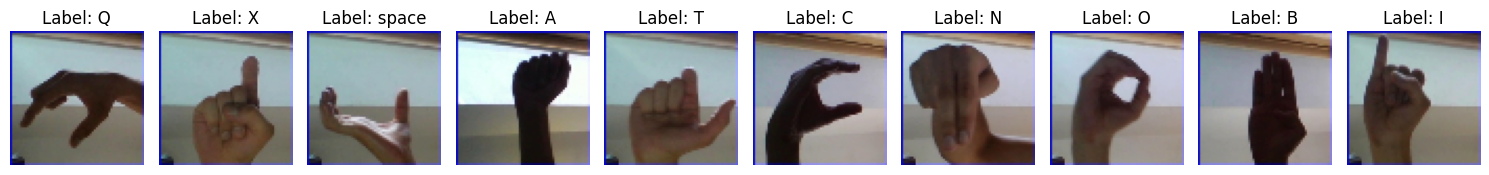

In [ ]:
num_samples = 10
plt.figure(figsize=(15, 5))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
# Data Preprocessing
X_train = X_train / 255.0
X_test = X_test / 255.0

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit on all labels (training + testing) to ensure consistency
all_labels = np.concatenate((y_train, y_test), axis=0)
label_encoder.fit(all_labels)

# Encode labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train_encoded, num_classes=29)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=29)

# Display information
print("Classes:", label_encoder.classes_)
print("Sample encoded labels:", y_train_encoded[:10])
print(f"y_train_encoded shape: {y_train_encoded.shape}")
print(f"y_test_encoded shape: {y_test_encoded.shape}")


Classes: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'del' 'nothing' 'space']
Sample encoded labels: [27 27 27 27 27 27 27 27 27 27]
y_train_encoded shape: (87000,)
y_test_encoded shape: (28,)


In [ ]:
model = Sequential([
    # Initial layers
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.1),

    # Second block
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.2),

    # Third block
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.3),

    # Fourth block
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.4),

    # Flatten and Dense layers
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(29, activation='softmax', kernel_regularizer=l2(0.001))
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                        

In [23]:

X = X_train[:86990:5]
y = y_train_one_hot[:86990:5]
print(len(X),len(y))

17398 17398


In [ ]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True  # Restore the best model weights
)

# Fit the model
history = model.fit(
    X, y,
    validation_data=(X_test, y_test_one_hot),
    epochs=10,                # Set a high number of epochs to allow early stopping to take effect
    batch_size=256,            # Adjust batch size as needed
    callbacks=[early_stopping],
    verbose=1
)



# Print training results
print("Training complete. Model stopped at the best epoch.")

Epoch 1/10
68/68 [==============================] - 1760s 26s/step - loss: 6.5189 - accuracy: 0.4443 - val_loss: 26.3915 - val_accuracy: 0.0357
Epoch 2/10
68/68 [==============================] - 1755s 26s/step - loss: 5.1635 - accuracy: 0.6962 - val_loss: 23.8173 - val_accuracy: 0.0357
Epoch 3/10
68/68 [==============================] - 1753s 26s/step - loss: 4.2719 - accuracy: 0.8453 - val_loss: 22.1274 - val_accuracy: 0.0357
Epoch 4/10
68/68 [==============================] - 1750s 26s/step - loss: 3.6248 - accuracy: 0.9159 - val_loss: 20.7859 - val_accuracy: 0.0357
Epoch 5/10
68/68 [==============================] - 1750s 26s/step - loss: 3.1186 - accuracy: 0.9480 - val_loss: 13.2253 - val_accuracy: 0.0357
Epoch 6/10
68/68 [==============================] - 1751s 26s/step - loss: 2.6851 - accuracy: 0.9668 - val_loss: 6.4370 - val_accuracy: 0.1786
Epoch 7/10
14/68 [=====>........................] - ETA: 23:08 - loss: 2.4377 - accuracy: 0.9794